In [44]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo
import FwtModels as mf

me.mechanics_printing()

In [45]:
test_num = 6

b_modes = 4
t_modes = 1
modes = b_modes + t_modes
main_panels = 20
panels = main_panels

p = ma.DynamicModelParameters(modes)

## Create some global parameters
p.c = ma.ModelSymbol(value = 0.15,string = 'c') # chord of wing
p.s = ma.ModelSymbol(value = 1.345,string = 's') # total semi-span of wing
p.rho_t = ma.ModelSymbol(value = 19.53,string = 'rho_t') # per per unit area (kg/m^2)

p.b_modes = ma.ModelSymbol(value = b_modes,string = 'b_modes') # percentage of wing that is a FWT
p.t_modes = ma.ModelSymbol(value = t_modes,string = 't_modes') # percentage of wing that is a FWT

# Inner Wing stiffness Properties
p.EI = ma.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing
p.GJ = ma.ModelSymbol(value = 0.99e6,string = 'GJ') # Torsional Stiffness for the wing

# Location of flexural axes
p.e = ma.ModelSymbol(value = 0.08,string = 'e')
p.x_f = ma.ModelSymbol(value = 0.08,string = 'x_f')

# Symbols to translate along inner wing and FWT
p.y_0 = sym.Symbol('y_0') # inner wing y chord
p.x_0 = sym.Symbol('x_0') # inner wing x chord

## Aero Parameters
p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha_r = ma.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = ma.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term

## Main Wing Specific
p.a = ma.ModelSymbol(value = 2*np.pi,string = 'a')               # C_L slope of main wing

## Numeric Model Constants
p.fp = ma.ModelMatrix(value =[0]*p.qs*2,length=p.qs*2,string='fp') # The stationary point

# Factor to change the size of joint values
p.eta = ma.ModelMatrix(value = [1]*modes,length=modes,string='eta')

In [46]:
#get shape functions for main wing
z_0,tau_0 = ele.FlexiElement.ShapeFunctions_BN_TM(b_modes,t_modes,p.q,p.y_0,p.x_0,p.x_f,0,factor=p.eta)

# apply weighting function
#define wrefernce frames
wing_root_frame = ma.HomogenousTransform().R_y(p.alpha_r)
wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.subs({p.x_0:p.x_f})

In [47]:
#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t)

wing_stiffness_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s,p.x_f,p.EI,p.GJ,gravityPot=True)

In [48]:
z_0.free_symbols

In [49]:
# Main Wing Aero Forces 
wing_AeroForces = ef.AeroForce.PerUnitSpan(p,wing_flexural_frame,p.a,
                               alphadot = 0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e,
                               w_g = 0,
                               root_alpha = p.alpha_r,
                                delta_alpha = tau_0,
                               alpha_zero = 0,
                               stall_angle = 0,
                               c = p.c,
                                V = p.V,
                               c_d_max = 0,
                               linear = True,
                                z_inverted=False).integrate((p.y_0,0,p.s))

# split Main Wing into segments
# forces = []
# for i in range(main_panels):
#     seg_width = p.s/main_panels
#     yi = seg_width/2 + i*seg_width
#     forces.append(wing_AeroForces.subs({p.y_0:yi,p.a_i:p.a[i]})*seg_width)
    
    
# forces = []
# for i in range(fwt_panels):
#     seg_width = p.s_1/fwt_panels
#     yi = seg_width/2 + i*seg_width
#     forces.append(wing_AeroForces.subs({p.y_0:yi,p.a_i:p.a[i]})*seg_width)
    
# Q = sym.Matrix([0]*p.qs)
# for f in forces:
#     Q += f.Q()
# wing_AeroForces = ef.ExternalForce(Q)

In [50]:
#Create Composite force
CompositeForce = ef.CompositeForce([wing_AeroForces])
# Create the SYmbolic Model
sm = ma.SymbolicModel.FromElementsAndForces(p,[wing_stiffness_ele],CompositeForce)

In [51]:
sm.to_matlab_file(p,'C:/Git/fwt_auto/+model/')

In [52]:
sm_lin = sm.linearise(p)

In [53]:
sm_lin.to_matlab_file_linear(p,'C:/Git/fwt_auto/+model/')

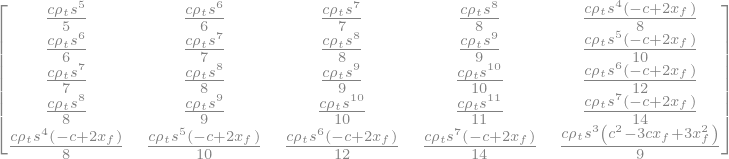

In [54]:
sym.simplify(sm.M.subs({i:1 for i in p.eta}))

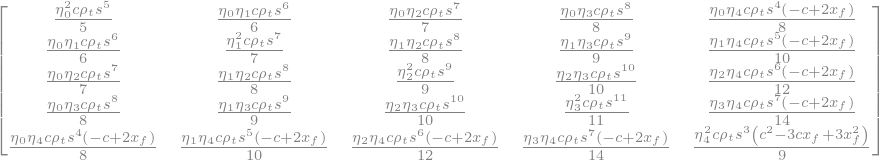

In [55]:
sym.simplify(sm.M)

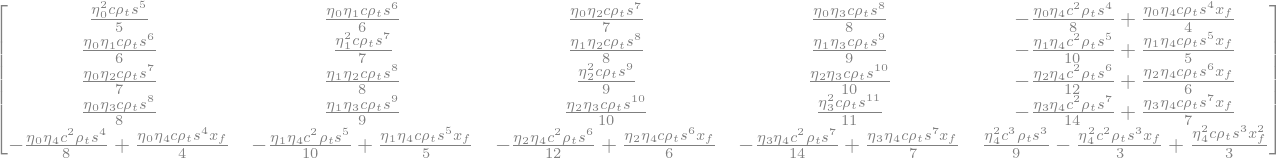

In [56]:
sm.M

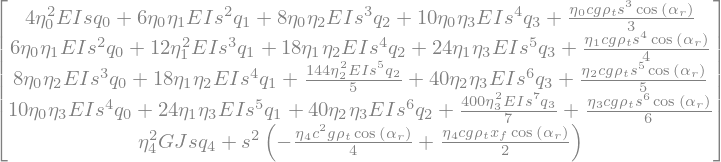

In [57]:
sm.f

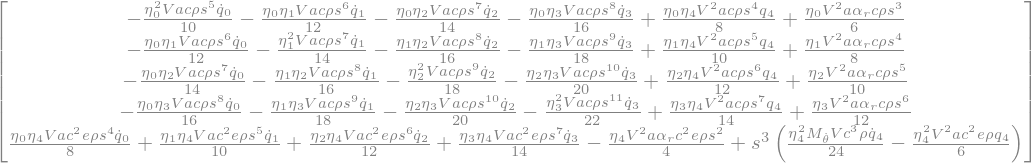

In [58]:
sm.ExtForces.Q()